In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
datos = pd.read_excel("02.Generación Pearson Photovoltaic.xlsx")
datos["Generacion_prev_hour"] = datos["Generación"].shift(1)
datos = datos.dropna(how="any", axis= 0)
datos.index = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M:%s')
datos = datos.drop(columns='Fecha', axis=1)
datos = datos[(datos['Hora']>=6) & (datos['Hora']<=19)]
datos.head(4)

,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour
Fecha,,,,,,,,,
2022-09-01 06:00:00,0.000000,0.0,18,6,16,54,3,89,0.000000
2022-09-01 07:00:00,6.584959,0.0,18,7,17,70,4,95,0.000000
2022-09-01 08:00:00,560.422022,0.0,18,8,18,72,3,100,6.584959
2022-09-01 09:00:00,7720.582326,1.0,18,9,18,81,4,100,560.422022


División de datos en Soleado, nublado y lluvioso

In [3]:
datosX = datos[['Índice UV', 'Temperatura', 'Hora', 'DPT',
       'Cobertura Nubes', 'Condición Cielo', 'Humedad Relativa',
       'Generacion_prev_hour']]

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(datosX)

In [5]:
from sklearn.mixture import GaussianMixture
# Definir el número de clusters (puedes ajustar el valor de n_components)
n_clusters = 3  # Puedes probar con otros valores
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
clusters = gmm.fit_predict(X_scaled)

In [6]:
datos['Cluster'] = clusters
datos

,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour,Cluster
Fecha,,,,,,,,,,
2022-09-01 06:00:00,0.000000,0.0,18,6,16,54,3,89,0.000000,2
2022-09-01 07:00:00,6.584959,0.0,18,7,17,70,4,95,0.000000,2
2022-09-01 08:00:00,560.422022,0.0,18,8,18,72,3,100,6.584959,2
2022-09-01 09:00:00,7720.582326,1.0,18,9,18,81,4,100,560.422022,2
2022-09-01 10:00:00,9433.109309,2.0,19,10,18,89,4,93,7720.582326,2
...,...,...,...,...,...,...,...,...,...,...
2024-10-02 15:00:00,25562.000000,5.0,25,15,8,43,3,34,25399.000000,1
2024-10-02 16:00:00,25386.000000,4.0,26,16,8,25,2,31,25562.000000,0
2024-10-02 17:00:00,22872.000000,2.0,26,17,8,18,1,32,25386.000000,0


In [7]:
print(datos['Cluster'].value_counts())
# Calcular estadísticas de cada cluster
cluster_means = datos.groupby('Cluster').mean()
cluster_means

Cluster
0    4170
1    3240
2    3230
Name: count, dtype: int64


,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour
Cluster,,,,,,,,,
0,21415.756950,5.717770,24.942926,14.378657,8.026619,16.220384,1.315588,34.763309,22608.303011
1,18699.424944,2.883673,23.033642,14.749383,9.027160,81.955864,3.727160,43.929630,20213.767521
2,6637.023839,0.894118,13.698762,7.818266,10.952632,59.483282,3.046130,84.386068,2425.852900


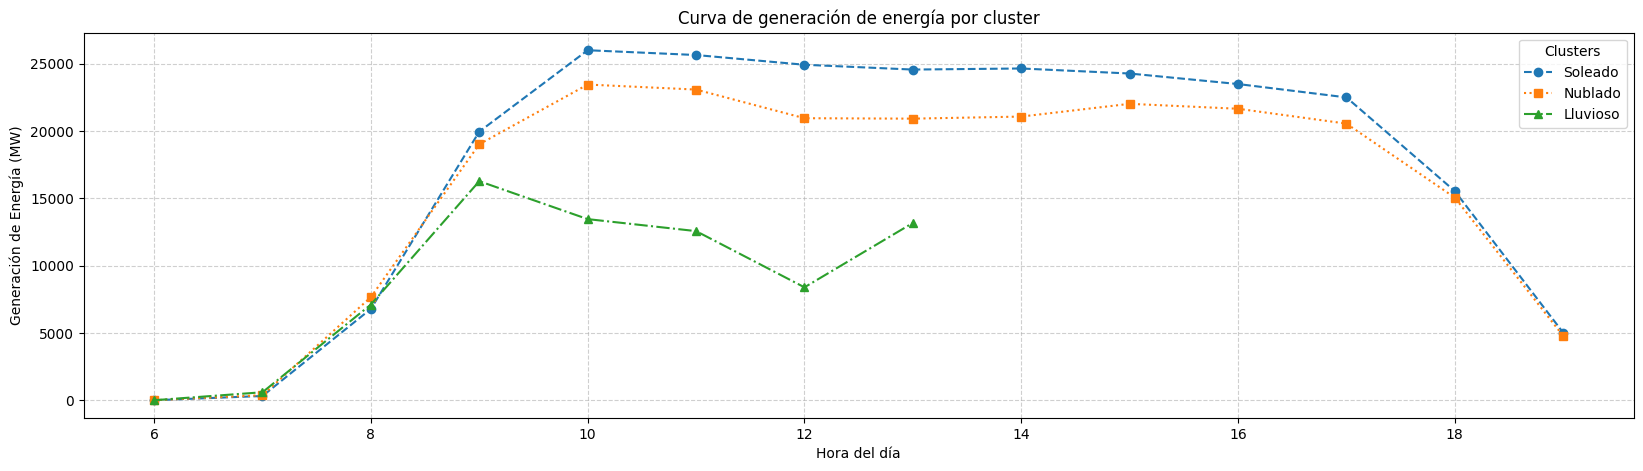

In [8]:
import matplotlib.pyplot as plt
df_grouped = datos.groupby(['Hora', 'Cluster'])['Generación'].mean().reset_index()

plt.figure(figsize=(20,5))

clusters = df_grouped['Cluster'].unique()

# Definir estilos para cada cluster
line_styles = ['dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1)), (0, (5, 1))]
markers = ['o', 's', '^', 'D', 'x']

# Dibujar una línea para cada cluster
for i, cluster in enumerate(clusters):
    if cluster == 0:
        label = 'Soleado'
    if cluster == 1:
        label = 'Nublado'
    if cluster == 2:
        label = 'Lluvioso'
    subset = df_grouped[df_grouped['Cluster'] == cluster]
    plt.plot(subset['Hora'], subset['Generación'], 
             linestyle=line_styles[i % len(line_styles)], 
             marker=markers[i % len(markers)], 
             label=label)

# Configuración de la gráfica
plt.xlabel("Hora del día")
plt.ylabel("Generación de Energía (MW)")
plt.title("Curva de generación de energía por cluster")
plt.legend(title="Clusters")
plt.grid(True, linestyle="--", alpha=0.6)

# Mostrar la gráfica
plt.show()

Cluster 0: Soleado, Cluster 1: Nublado, Cluster 2: Lluvioso

Entrenamiento 70-30

In [9]:
import numpy as np
def datos_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [92]:
WINDOW_SIZE = 10
X_Soleado, y_Soleado = datos_to_X_y(datos[datos['Cluster']==0].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Nublado, y_Nublado = datos_to_X_y(datos[datos['Cluster']==1].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Lluvioso, y_Lluvioso = datos_to_X_y(datos[datos['Cluster']==2].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Soleado.shape, y_Soleado.shape, X_Nublado.shape, y_Nublado.shape, X_Lluvioso.shape, y_Lluvioso.shape

((4160, 10, 9), (4160,), (3230, 10, 9), (3230,), (3220, 10, 9), (3220,))

In [93]:
num_datos_Soleado = X_Soleado.shape[0]
train_Soleado = int(round(num_datos_Soleado * 0.7,0))
val_Soleado = int(train_Soleado + round((num_datos_Soleado - train_Soleado) / 2, 0))

num_datos_Nublado = X_Nublado.shape[0]
train_Nublado = int(round(num_datos_Nublado * 0.7,0))
val_Nublado = int(train_Nublado + round((num_datos_Nublado - train_Nublado) / 2, 0))

num_datos_Lluvioso = X_Lluvioso.shape[0]
train_Lluvioso = int(round(num_datos_Lluvioso * 0.7,0))
val_Lluvioso = int(train_Lluvioso + round((num_datos_Lluvioso - train_Lluvioso) / 2, 0))

num_datos_Soleado, train_Soleado, val_Soleado, num_datos_Nublado, train_Nublado, val_Nublado, num_datos_Lluvioso, train_Lluvioso, val_Lluvioso

(4160, 2912, 3536, 3230, 2261, 2745, 3220, 2254, 2737)

In [94]:
X_Soleado_train, y_Soleado_train = X_Soleado[:train_Soleado], y_Soleado[:train_Soleado]
X_Soleado_test, y_Soleado_test = X_Soleado[train_Soleado:], y_Soleado[train_Soleado:]
X_Soleado_train.shape, y_Soleado_train.shape, X_Soleado_test.shape, y_Soleado_test.shape

((2912, 10, 9), (2912,), (1248, 10, 9), (1248,))

In [95]:
X_Nublado_train, y_Nublado_train = X_Nublado[:train_Nublado], y_Nublado[:train_Nublado]
X_Nublado_test, y_Nublado_test = X_Nublado[train_Nublado:], y_Nublado[train_Nublado:]
X_Nublado_train.shape, y_Nublado_train.shape, X_Nublado_test.shape, y_Nublado_test.shape

((2261, 10, 9), (2261,), (969, 10, 9), (969,))

In [96]:
X_Lluvioso_train, y_Lluvioso_train = X_Lluvioso[:train_Lluvioso], y_Lluvioso[:train_Lluvioso]
X_Lluvioso_test, y_Lluvioso_test = X_Lluvioso[train_Lluvioso:], y_Lluvioso[train_Lluvioso:]
X_Lluvioso_train.shape, y_Lluvioso_train.shape, X_Lluvioso_test.shape, y_Lluvioso_test.shape

((2254, 10, 9), (2254,), (966, 10, 9), (966,))

Definición del modelo

In [97]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.regularizers import l2

In [98]:
inputs = Input(shape=(WINDOW_SIZE, 9))

# Primera capa CNN
x = Conv1D(filters=64, kernel_size=4, padding='same', activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)

# Segunda capa CNN
x = Conv1D(filters=128, kernel_size=4, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# Capa BiGRU
x = Bidirectional(GRU(64, return_sequences=True))(x)

# Atención: se define de forma explícita
attention = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)

# Aplanar y agregar Dropout
x = Flatten()(attention)
x = Dropout(0.4)(x)
initializer = tf.keras.initializers.HeNormal()
x = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dense(32, activation="relu")(x)  # Otra capa intermedia

# Capa de salida
outputs = Dense(1, activation="linear")(x)

# Definir el modelo
model_Soleado = Model(inputs=inputs, outputs=outputs)

# Resumen del modelo
model_Soleado.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 10, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 10, 64)    │      2,368 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 5, 64)     │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 5, 128)    │     32,896 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 2, 128)    │          0 │ conv1d_19[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 2, 128)    │     74,496 │ max_pooling1d_19… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 128)    │    263,808 │ bidirectional_9[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 256)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 256)       │          0 │ flatten_9[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │     16,448 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 32)        │      2,080 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │         33 │ dense_25[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 392,129 (1.50 MB)

 Trainable params: 392,129 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
cp = ModelCheckpoint('Photovoltaic_model_Soleado.keras', save_best_only=True)
model_Soleado.compile(optimizer=Adam(learning_rate=0.0001), loss="mean_squared_error", metrics=['mae'])

In [100]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [101]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

In [102]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_Soleado_train = scaler_X.fit_transform(X_Soleado_train.reshape(-1, X_Soleado_train.shape[-1])).reshape(X_Soleado_train.shape)
X_Soleado_test = scaler_X.transform(X_Soleado_test.reshape(-1, X_Soleado_test.shape[-1])).reshape(X_Soleado_test.shape)

y_Soleado_train = scaler_y.fit_transform(y_Soleado_train.reshape(-1, 1)).reshape(-1)
y_Soleado_test = scaler_y.transform(y_Soleado_test.reshape(-1, 1)).reshape(-1)


In [103]:
X_Soleado_train.shape, y_Soleado_train.shape, X_Soleado_test.shape, y_Soleado_test.shape

((2912, 10, 9), (2912,), (1248, 10, 9), (1248,))

In [104]:
history = model_Soleado.fit(
    X_Soleado_train, y_Soleado_train,
    validation_data=(X_Soleado_test, y_Soleado_test),
    epochs=50,
    batch_size=16,
    callbacks=[cp, early_stop]
)

Epoch 1/50


182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 1.1561 - mae: 0.3558 - val_loss: 0.7866 - val_mae: 0.1759
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.7420 - mae: 0.1917 - val_loss: 0.5587 - val_mae: 0.1436
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.5291 - mae: 0.1774 - val_loss: 0.3971 - val_mae: 0.1393
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.3764 - mae: 0.1642 - val_loss: 0.2834 - val_mae: 0.1361
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.2703 - mae: 0.1615 - val_loss: 0.2073 - val_mae: 0.1381
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2002 - mae: 0.1639 - val_loss: 0.1491 - val_mae: 0.1295
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1452 - mae: 0.1523 - val_loss: 0.1186 - val_mae: 0.1437
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1123 - mae: 0.1523 - val_loss: 0.0901 - val_mae: 0.1335
Epoch 9/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - los

In [105]:
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error as mean_absolute_error
from sklearn.metrics import mean_squared_error as mean_squared_error
from sklearn.metrics import r2_score as r2_score
def plot_predictions1(model, X, y, scaler_y, history, start=0, end=100):
    predictions = model.predict(X).flatten()
    y = y.flatten()
    predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)
    predictions_original = np.clip(predictions_original, 0, 30000)
    y_original = scaler_y.inverse_transform(y.reshape(-1, 1)).reshape(-1)
    df = pd.DataFrame(data={'Predictions': predictions_original, 'Actuals': y_original})
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Crear la gráfica
    print(f"MAE: {mean_absolute_error(y_original, predictions_original):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_original, predictions_original)):.4f}")
    print(f"R²: {r2_score(y_original, predictions_original):.4f}")
    plt.plot(train_loss, label='Pérdida Entrenamiento')
    plt.plot(val_loss, label='Pérdida Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la Pérdida')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(y_original, label='Valor Real', color='blue')
    plt.plot(predictions_original, label='Predicción', color='red', linestyle='dashed')
    plt.xlabel("Hora")
    plt.ylabel("Valor")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MAE: 3265.3731
RMSE: 4834.2962
R²: 0.5241


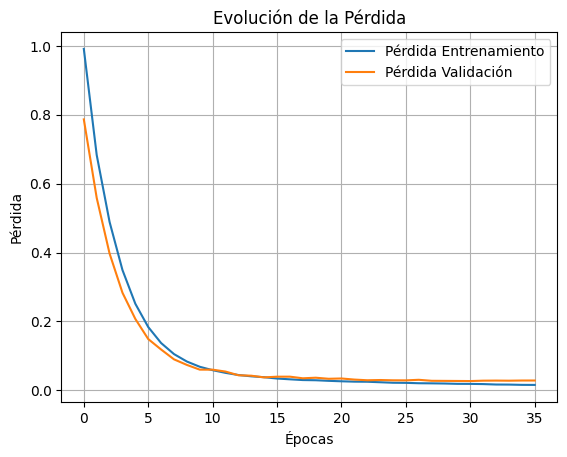

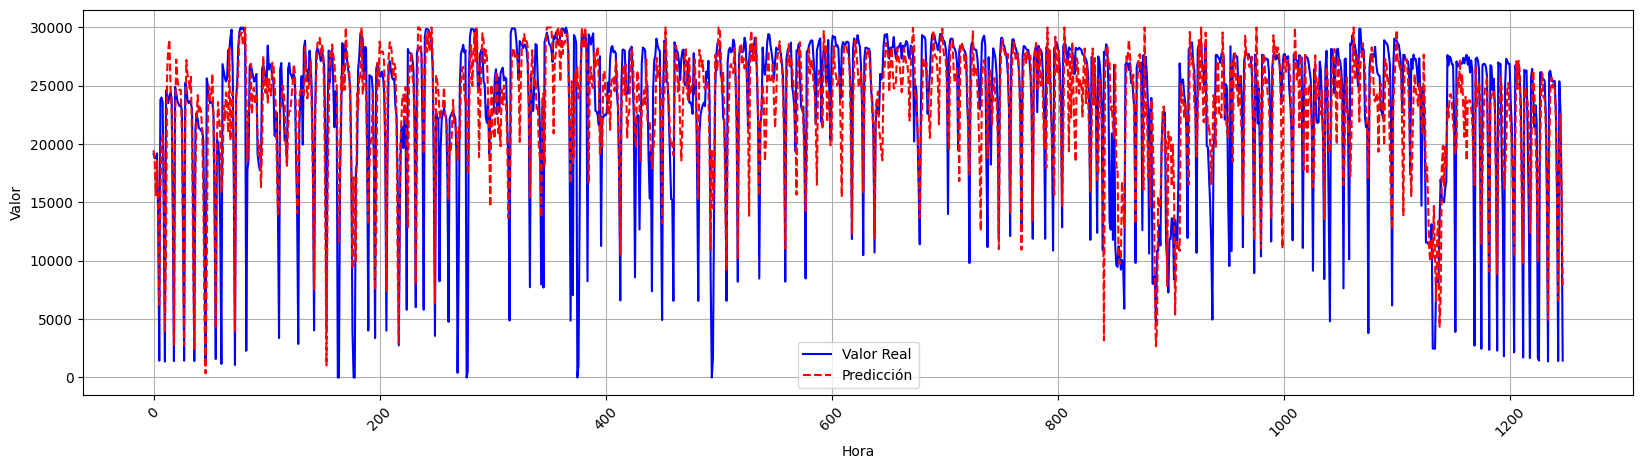

In [106]:
plot_predictions1(model_Soleado, X_Soleado_test, y_Soleado_test, scaler_y, history)